# Injection recovery through bilby

Inject a signal through pycbc and recover with bilby

In [80]:
import bilby
import numpy as np

import matplotlib.pyplot as plt
import config
config.conf_matplolib()

# Load injection polarization data

In [81]:
inj_data = np.genfromtxt("prepared_waveform_imr_fseries_2.txt")

In [82]:
inj_data.shape

(16385, 3)

## waveform params

In [95]:
# Simulation name
sim_name = 'IMRPhenomD_q2'

# Parameters
Mtotal = 60
q=0.5
mass_2 = Mtotal*q/(1+q)
mass_1 = Mtotal/(1+q)
D = 100
inc = 0
coa_phase = 0
sampling_frequency=2048
delta_t = 1./sampling_frequency
analysis_duration = 16#15.99951171875

minimum_frequency = 20
merger_time = 0



print("Analysis duration is ", analysis_duration)


injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0,
    phi_jl=0,
#    spin_1x=0,
#    spin_1y=0,
#    spin_1z=0,
#    spin_2x=0,
#    spin_2y=0,
#    spin_2z=0,
    luminosity_distance=D,
    geocent_time=merger_time,
    theta_jn=inc,
    psi=0,
    phase=coa_phase,
    ra=1.375,
    dec=-1.2108,
)



Analysis duration is  16


## Plot the f-domain strain

In [96]:
inj_data.shape

(16385, 3)

In [97]:
2*1076*delta_t

1.05078125

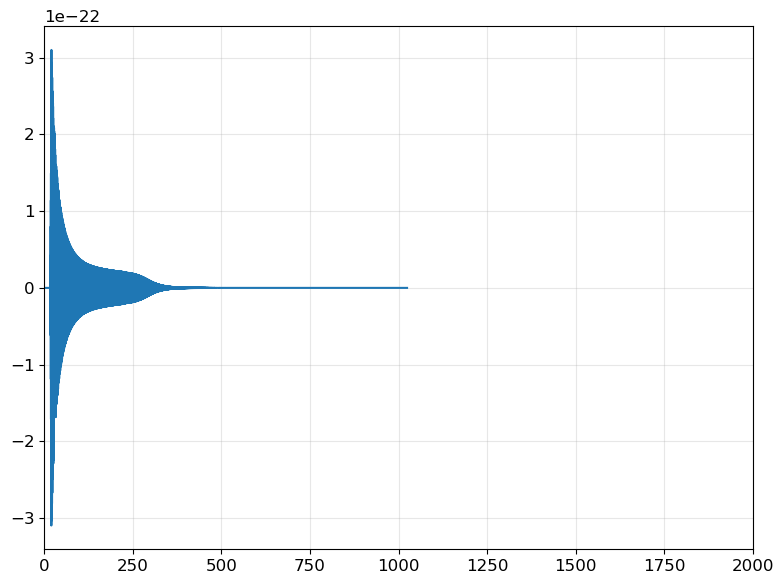

In [98]:
hp0 = inj_data[:, 1]
hc0 = inj_data[:, 2]

maxloc = np.argmax(hp0**2 + hc0**2)

hf0 = inj_data[:, 0]
#ht0 -= ht0[maxloc]
#ht0 += merger_time

plt.plot(hf0, hp0)
plt.xlim(0 ,2000)
plt.show()

In [99]:
# injection dictionary
fdomain_pol_dict = {"plus": hp0, "cross": hc0}

In [100]:

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = f"fast_tutorial_apx_{sim_name}_inj_f_two_sonic_1"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
#bilby.core.utils.random.seed(88170235)

# Create sampler waveform model

In [101]:

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20.0,
    minimum_frequency=minimum_frequency,
)

In [102]:

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=analysis_duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
    )

11:14 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Inject the signal

In [103]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=analysis_duration,
    start_time= merger_time - analysis_duration,
)

#new_time = np.linspace(ht0[0], ht0[-1], 4097)

#inj_pol_dict = fdomain_pol_dict#nr_injection(new_time)

print(fdomain_pol_dict['plus'].shape)

# Create a different waveform generator for injection
injection = ifos.inject_signal(
    injection_polarizations=fdomain_pol_dict, 
    parameters=injection_parameters
)


11:14 bilby INFO    : Injected signal in H1:
11:14 bilby INFO    :   optimal SNR = 124.24
11:14 bilby INFO    :   matched filter SNR = 124.12+0.34j
11:14 bilby INFO    :   mass_1 = 40.0
11:14 bilby INFO    :   mass_2 = 20.0
11:14 bilby INFO    :   a_1 = 0.0
11:14 bilby INFO    :   a_2 = 0.0
11:14 bilby INFO    :   tilt_1 = 0.0
11:14 bilby INFO    :   tilt_2 = 0.0
11:14 bilby INFO    :   phi_12 = 0
11:14 bilby INFO    :   phi_jl = 0
11:14 bilby INFO    :   luminosity_distance = 100
11:14 bilby INFO    :   geocent_time = 0
11:14 bilby INFO    :   theta_jn = 0
11:14 bilby INFO    :   psi = 0
11:14 bilby INFO    :   phase = 0
11:14 bilby INFO    :   ra = 1.375
11:14 bilby INFO    :   dec = -1.2108


(16385,)


## Plot ASD

/tmp/ipykernel_3140482/2281181904.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1000)


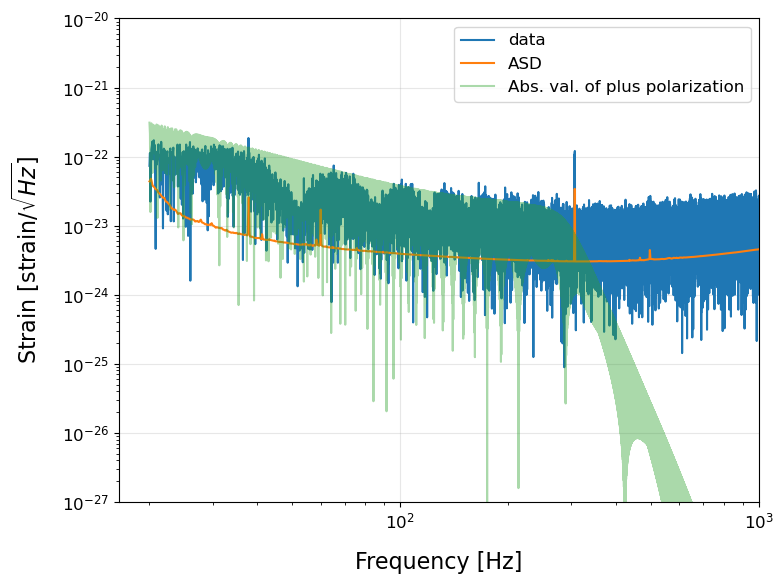

In [104]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization", alpha=0.4)

ax.set_ylim(1e-27, 1e-20)
ax.set_xlim(0, 1000)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [105]:
H1_injection["plus"][idxs]

array([ 3.09962443e-22, -2.13028563e-22, -1.57419776e-23, ...,
       -2.26848562e-38, -9.63876337e-39,  7.34683969e-40])

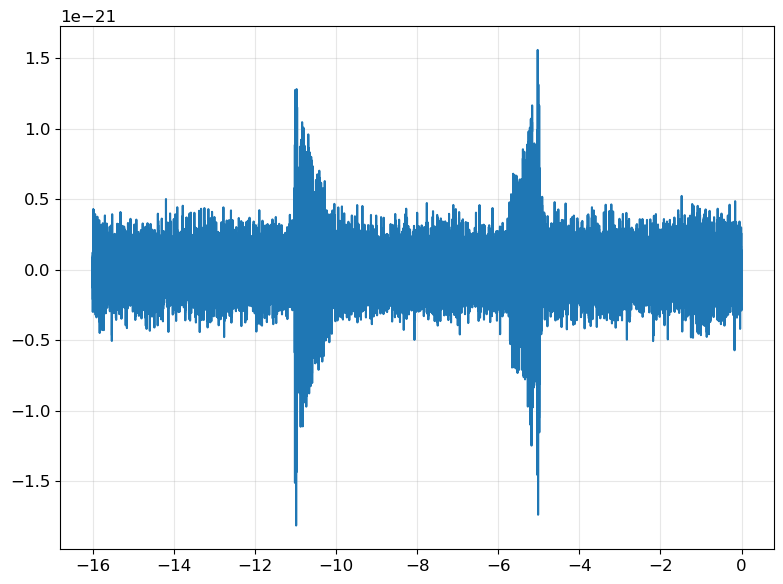

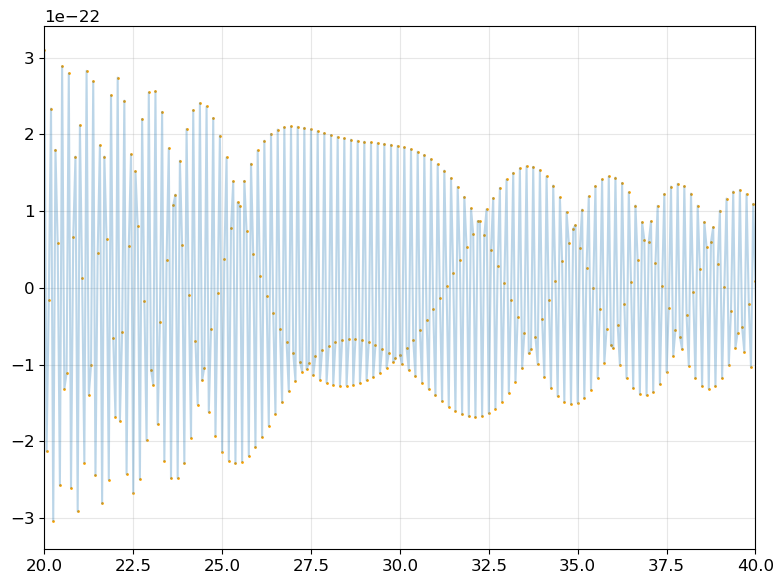

In [106]:
plt.plot(H1.strain_data.time_array, H1.strain_data.time_domain_strain)
plt.show()


plt.plot(H1.frequency_array[idxs], H1_injection["plus"][idxs], label='inj', alpha=0.3)
plt.scatter(hf0, hp0, label='prep', s=1, c='orange')
plt.xlim(20, 40)
plt.show()

In [107]:
print(fdomain_pol_dict['plus'].shape)

(16385,)


## Setup priors

In [108]:

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
from bilby.core.prior import Uniform
priors['chirp_mass'] = Uniform(name='chirp_mass', minimum=15.0,maximum=50)


for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "luminosity_distance",
    "theta_jn",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(analysis_duration, minimum_frequency)


11:14 bilby INFO    : No prior given, using default BBH priors in /mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


True

## Setup likelihood

In [109]:

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator,time_marginalization=False, phase_marginalization=False, distance_marginalization=False
)

In [110]:
injection_parameters['geocent_time']

0

In [111]:
mass_1, mass_2

(40.0, 20.0)

## Run sampler

In [112]:

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=500,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    dlogz=3,
)

11:14 bilby INFO    : Running for label 'fast_tutorial_apx_IMRPhenomD_q2_inj_f_two_sonic_1', output will be saved to 'outdir'
11:14 bilby INFO    : Using lal version 7.5.0
11:14 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:14 bilby INFO    : Using lalsimulation version 5.4.0
11:14 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:14 bilby INFO    : Analysis priors:
11:14 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
11:14 bilby INFO    : chirp_mass=Uniform(minimum=15.0, maximum=50, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, bound

1it [00:00, ?it/s]

11:15 bilby INFO    : Written checkpoint file outdir/fast_tutorial_apx_IMRPhenomD_q2_inj_f_two_sonic_1_resume.pickle
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
11:26 bilby INFO    : Written checkpoint file outdir/fast_tutorial_apx_IMRPhenomD_q2_inj_f_two_sonic_1_resume.pickle
/mnt/pfs/v

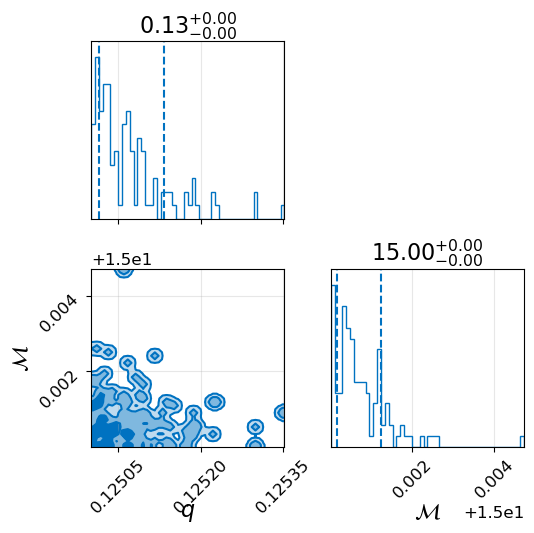

In [113]:
# Make a corner plot.
result.plot_corner()

In [115]:
mass_1

40.0

In [116]:
def ChirpMassFromIndividualMasses(mass_1, mass_2):

    return ((mass_1 * mass_2)**(3/5))/(mass_1 + mass_2)**(1/5)

In [117]:
Mchirp_act = ChirpMassFromIndividualMasses(mass_1, mass_2)

In [118]:
Mchirp_act

24.334573675728226

In [119]:
mass_1, mass_2

(40.0, 20.0)

In [120]:
bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)

24.334573675728226

In [121]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(50, q)

(82.1875914758613, 41.09379573793065)

In [122]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(100, q)

(164.3751829517226, 82.1875914758613)